# UPI Number fraud detection

## Brief Introduction

# Contents <a id='10'></a>

1. [Importing dependecies](#1)
2. [Data preprocessing](#2)
3. [Statistical Data Analysis](#3)
4. [Machine Learning Model building](#4)
5. [Training and Evaluation](#5)
6. [Hyper-parameter Tuning](#6)
7. [Key Observations of Shap and Lime images](#7)
8. [Summary](#8)
9. [Conclusion](#9)

## Importing depencies<a id='1'></a>
[back to content](#10)

I will be exploring data, visulazie the variables, perform statistical tests and perform classifcation of risk of fraud by the upi numbers. For this I will be needing, pandas, numpy, bayesian_testing, a statical testing module helpfull for performing A/B test. For Classification I will be using Superviesed Algorithms. For Evaluation, I will be using Kfold cross validation and ROC and AUC curves. I will also be using Lime and Shap modules for generating the explanations of the ml model performce results of a sample data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_testing.experiments import BinaryDataTest
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,auc
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import plotly.colors as colors
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, recall_score, precision_score, f1_score, make_scorer
import plotly.graph_objects as go
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')
import pickle
import shap
shap.initjs()
import lime
from lime import lime_tabular

## Data Preprocessing<a id='2'></a>
[back to content](#10)

In [ ]:
df = pd.read_csv('upi_fraud_dataset.csv')
df

Unnamed: 0  trans_hour  trans_day  trans_month  trans_year  category  \
0              0           0          1            1        2022        12   
1              1           1          1            1        2022         3   
2              2           3          1            1        2022         8   
3              3           6          1            1        2022         4   
4              4           6          1            1        2022         0   
...          ...         ...        ...          ...         ...       ...   
2661        2661          16          4            7        2022        13   
2662        2662          18          4            7        2022         5   
2663        2663          19          4            7        2022        11   
2664        2664          19          4            7        2022        10   
2665        2665          22          4            7        2022        10   

      upi_number  age  trans_amount  state    zip  fraud_risk  
0     9957000001   54         66.21     22  49879           0  
1     9957000002   15         55.81     14  62668           0  
2     9957000003   60          8.68      4  96037           0  
3     9957000004   44         89.52     40  29911           0  
4     9957000005   72          1.90     38  16421           0  
...          ...  ...           ...    ...    ...         ...  
2661  7662001080   56          3.49     10  31561           0  
2662  7662001081   61        116.09     35  43330           0  
2663  7662001082   61        885.19      1  36009           1  
2664  7662001083   73          1.37     43  76631           0  
2665  7662001084   38         76.22     23  56321           0  

[2666 rows x 12 columns]

The data set contains 2666 rows of information spread out in 12 columns. We can ignore the Unmaed 0 column as it is just the index column.

In [ ]:
df.isnull().sum()

Unnamed: 0      0
trans_hour      0
trans_day       0
trans_month     0
trans_year      0
category        0
upi_number      0
age             0
trans_amount    0
state           0
zip             0
fraud_risk      0
dtype: int64

The dataset is clean and there are no null values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2666 non-null   int64  
 1   trans_hour    2666 non-null   int64  
 2   trans_day     2666 non-null   int64  
 3   trans_month   2666 non-null   int64  
 4   trans_year    2666 non-null   int64  
 5   category      2666 non-null   int64  
 6   upi_number    2666 non-null   int64  
 7   age           2666 non-null   int64  
 8   trans_amount  2666 non-null   float64
 9   state         2666 non-null   int64  
 10  zip           2666 non-null   int64  
 11  fraud_risk    2666 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 250.1 KB


Except for transaction amount, all the other data fields are integers

## Statistical Data Analysis<a id='3'></a>
<a href='' style="float:right">[back to contents](#10)</a>

In [ ]:
df.describe()

Unnamed: 0   trans_hour    trans_day  trans_month  trans_year  \
count  2666.000000  2666.000000  2666.000000  2666.000000      2666.0   
mean   1332.501500    13.383721    13.552138     3.868717      2022.0   
std     769.753574     8.669769    10.316915     3.198150         0.0   
min       0.000000     0.000000     1.000000     1.000000      2022.0   
25%     666.250000     3.000000     3.000000     2.000000      2022.0   
50%    1332.500000    15.000000    15.000000     3.000000      2022.0   
75%    1998.750000    22.000000    23.000000     5.000000      2022.0   
max    2665.000000    23.000000    31.000000    12.000000      2022.0   

          category    upi_number          age  trans_amount        state  \
count  2666.000000  2.666000e+03  2666.000000   2666.000000  2666.000000   
mean      6.800075  8.045540e+09    46.098275    329.844299    27.153788   
std       3.826561  1.027994e+09    18.863370    385.964247    14.084107   
min       0.000000  6.900000e+09    14.000000      1.020000     0.000000   
25%       4.000000  7.086000e+09    31.000000     20.987500    15.000000   
50%       7.000000  7.662001e+09    45.000000    113.255000    29.000000   
75%      11.000000  9.101000e+09    58.000000    715.187500    38.000000   
max      13.000000  9.957000e+09    94.000000   3413.050000    50.000000   

                zip   fraud_risk  
count   2666.000000  2666.000000  
mean   48219.701800     0.591898  
std    26617.172444     0.491574  
min     1330.000000     0.000000  
25%    25132.750000     0.000000  
50%    48088.000000     1.000000  
75%    68881.000000     1.000000  
max    99783.000000     1.000000

### correlation analysis

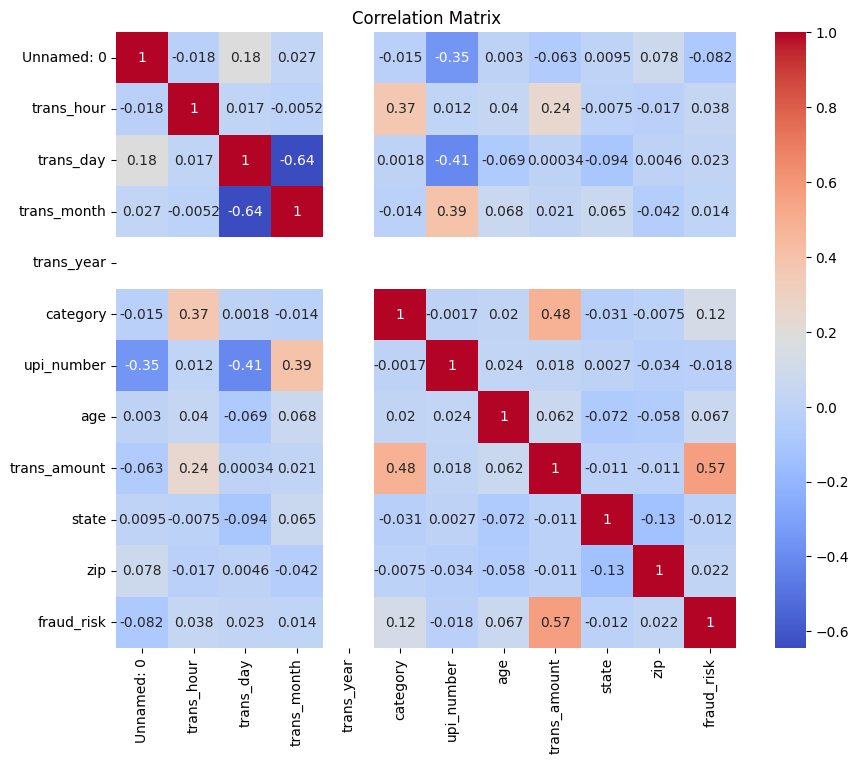

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Interpreting the Correlation Matrix

Looking at matrix, I observe the following:

**Strong Positive Correlations:**

**trans_amount and fraud_risk:** There's a strong positive correlation between transaction amount and fraud risk. This suggests that larger transactions are more likely to be fraudulent.

**Strong Negative Correlations:**

**trans_day and trans_month:** There's a strong negative correlation between transaction day and transaction month. This could be due to seasonal variations or specific patterns in the data.

**trans_year and trans_month:** Similarly, there's a strong negative correlation between transaction year and transaction month, possibly due to annual trends or specific events.

### Other Notable Correlations:

**category and trans_amount:** There's a moderate positive correlation between transaction category and transaction amount. This suggests that certain categories of transactions might be associated with higher amounts.

**age and fraud_risk:** There's a moderate positive correlation between age and fraud risk. This could indicate that older individuals might be more susceptible to fraud or have different fraud patterns.

### Finding Outliers

Outliers using Z-score: 1438    3413.05
Name: trans_amount, dtype: float64
Outliers using IQR: 1438    3413.05
Name: trans_amount, dtype: float64


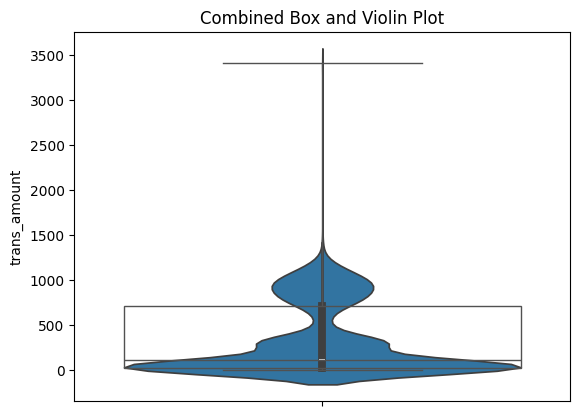

In [ ]:
# Function to detect outliers using Z-score
def detect_outliers_zscore(data, threshold=3):
    z_scores = (data - data.mean()) / data.std()
    outliers = data[np.abs(z_scores) > threshold]
    return outliers

# Function to detect outliers using IQR
def detect_outliers_iqr(data):
    q1, q3 = data.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

outliers_zscore = detect_outliers_zscore(df['trans_amount'])
outliers_iqr = detect_outliers_iqr(df['trans_amount'])

print("Outliers using Z-score:", outliers_zscore)
print("Outliers using IQR:", outliers_iqr)
sns.violinplot(y=df['trans_amount'])
sns.boxplot(y=df['trans_amount'], whis=np.inf, boxprops={'facecolor': 'none'})
plt.title('Combined Box and Violin Plot')
plt.show()

Interpreting Outliers:

Outliers are data points that significantly deviate from the general trend of the data. In this case, the value 3413.05 from transaction amount column is identified as an outlier using both Z-score and IQR methods. So I will be removing the row corresponding to the outlier value of trans_amount

In [ ]:
"""z_scores = np.abs(stats.zscore(df['trans_amount']))
threshold = 3
df_filtered = df[z_scores < threshold]"""
# I will use Interquartile range to remove instead of Z-scores
Q1 = df['trans_amount'].quantile(0.25)
Q3 = df['trans_amount'].quantile(0.75)
IQR = Q3 - Q1

df_filtered = df[(df['trans_amount'] >= Q1 - 1.5*IQR) & (df['trans_amount'] <= Q3 + 1.5*IQR)]

### Bayesian Hypothesis testing

I am assumming to test if the average transaction amount for fraudulent transactions is significantly different from the average transaction amount for non-fraudulent transactions.

**Hypotheses:**

**Null Hypothesis (H₀):** The average transaction amount for fraudulent and non-fraudulent transactions is the same.

**Alternative Hypothesis (H₁):** The average transaction amount for fraudulent and non-fraudulent transactions is different.

In [ ]:
from bayesian_testing.experiments import PoissonDataTest

fraudulent_transactions = df_filtered[df_filtered['fraud_risk'] == 1]['trans_amount']
non_fraudulent_transactions =df_filtered[df_filtered['fraud_risk'] == 0]['trans_amount']
#initialize a test:
test = PoissonDataTest()

test.add_variant_data("fraudulent_transactions", fraudulent_transactions)
test.add_variant_data("non_fraudulent_transactions", non_fraudulent_transactions)
test.add_variant_data_agg("Aggregated_Values", len(df_filtered),sum(fraudulent_transactions))
# evaluate test:
results = test.evaluate()
results
print(pd.DataFrame(results).set_index('variant').T.to_markdown(tablefmt="grid"))

+-------------------+----------------------------+-------------------------------+---------------------------+
|                   | fraudulent_transactions    | non_fraudulent_transactions   | Aggregated_Values         |
+===================+============================+===============================+===========================+
| totals            | 1578                       | 1087                          | 2665                      |
+-------------------+----------------------------+-------------------------------+---------------------------+
| sum_values        | 806633.0899999993          | 69318.75999999992             | 806633.0899999993         |
+-------------------+----------------------------+-------------------------------+---------------------------+
| observed_average  | 511.17433                  | 63.77071                      | 302.67658                 |
+-------------------+----------------------------+-------------------------------+---------------------------+
|

Totals, Sum Values, and Observed Average:
Totals: The total number of transactions in each group and the overall total.
Sum Values: The sum of transaction amounts within each group and the overall total.
Observed Average: The simple average of transaction amounts for each group and the overall average.
Posterior Mean:
This is the estimated mean transaction amount for each group based on a Bayesian statistical model. It takes into account both the observed data and prior beliefs about the distribution of transaction amounts.
Credible Interval:
This is a range of values within which the true mean transaction amount for each group is likely to fall with a certain level of confidence (often 95%).
Prob Being Best:
This indicates the probability that a particular group has the highest mean transaction amount. In this case, the "fraudulent_transactions" group has a probability of 1.0, suggesting it has the highest mean.
Expected Loss:
This metric is less straightforward without additional context. It might be related to a decision-making problem where you want to minimize the expected loss associated with different actions. In this case, the "non-fraudulent_transactions" group has a higher expected loss, which might suggest that it's more important to focus on this group for further analysis or intervention.
Interpretation of the Results:

Based on the results, we can conclude that:

The average transaction amount for fraudulent transactions is significantly higher than that for non-fraudulent transactions.
There is high confidence in the estimated mean transaction amounts for both groups, as indicated by the narrow credible intervals.
The model strongly suggests that the fraudulent transactions group has the highest mean transaction amount.
The higher expected loss for the non-fraudulent group might indicate potential risks or areas where further investigation is needed.

# Machine Learning Model<a id='4'></a>
[back to contents](#10)

# ML model Training and Evaluation<a id='5'></a>
[back to contents](#10)

In [ ]:
features =  df_filtered[['trans_hour','trans_day', 'trans_month', 'trans_year', 'category', 'upi_number', 'age', 'trans_amount', 'state', 'zip']]
target = df_filtered['fraud_risk']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state = 200, test_size = 0.15)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2265, 10)
(400, 10)
(2265,)
(400,)


In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
def train_and_evaluate_models(x_train_scaled, y_train, x_test_scaled, y_test):
    models_list = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        HistGradientBoostingClassifier(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        AdaBoostClassifier(),
        GaussianNB()
    ]

    for model in models_list:
        model.fit(x_train_scaled, y_train)
        y_pred = model.predict(x_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Accuracy of the {model} model: {accuracy:.2f}")
        print(f"Precision of the {model} model: {precision:.2f}")
        print(f"Recall of the {model} model: {recall:.2f}")
        print(f"F1-score of the {model} model: {f1:.2f}")
        print('\n ________________________________________________ \n')

In [ ]:
train_and_evaluate_models(x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy of the LogisticRegression() model: 0.80
Precision of the LogisticRegression() model: 0.90
Recall of the LogisticRegression() model: 0.73
F1-score of the LogisticRegression() model: 0.81

 ________________________________________________ 

Accuracy of the DecisionTreeClassifier() model: 0.94
Precision of the DecisionTreeClassifier() model: 0.94
Recall of the DecisionTreeClassifier() model: 0.96
F1-score of the DecisionTreeClassifier() model: 0.95

 ________________________________________________ 

Accuracy of the HistGradientBoostingClassifier() model: 0.95
Precision of the HistGradientBoostingClassifier() model: 0.94
Recall of the HistGradientBoostingClassifier() model: 0.97
F1-score of the HistGradientBoostingClassifier() model: 0.96

 ________________________________________________ 

Accuracy of the RandomForestClassifier() model: 0.95
Precision of the RandomForestClassifier() model: 0.95
Recall of the RandomForestClassifier() model: 0.98
F1-score of the RandomForestClassi

### **From the above results its very clear that**
- **DecisionTreeClassifier**,
- **HistGradientBoostingClassifier**,
- **RandomForestClassifier**,
- **GradientBoostingClassifier**
- **AdaBoostClassifier**

**are more accurate than the other models with their accuracy greater than 90%. So I will be increasing their performance with the help of Hyperparameter tuning**

## Hyper parameter tuning <a id='6'></a>
[back to contents](#10)

In [ ]:
# Define the parameter grids for each model
param_grid_decision_tree = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_hist_gradient_boosting = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_leaf_nodes':[10, 20, 15],
}

param_grid_random_forest = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

param_grid_gradient_boosting = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

param_grid_ada_boost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05, 0.01]
}

# Create a dictionary to store the models and their parameter grids
model_param_grid = {
    DecisionTreeClassifier(): param_grid_decision_tree,
    HistGradientBoostingClassifier(): param_grid_hist_gradient_boosting,
    RandomForestClassifier(): param_grid_random_forest,
    GradientBoostingClassifier(): param_grid_gradient_boosting,
    AdaBoostClassifier(): param_grid_ada_boost,
}
results = []
# Perform hyperparameter tuning and evaluate models
for model, param_grid in model_param_grid.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train_scaled, y_train)
    with open(f'best_{model}.pkl', 'wb') as f:  # Open in binary write mode
        pickle.dump(grid_search.best_estimator_, f)
        print(f"Best model for {model} saved successfully!")
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({'Model': model, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1})
    print(f"Best parameters for {model}: {grid_search.best_params_}")
    print(f"Accuracy of the {model} model: {accuracy:.2f}")
    print(f"Precision of the {model} model: {precision:.2f}")
    print(f"Recall of the {model} model: {recall:.2f}")
    print(f"F1-score of the {model} model: {f1:.2f}")
    print('\n _______________________________________________________________________________________________________________ \n')


Best model for DecisionTreeClassifier() saved successfully!
Best parameters for DecisionTreeClassifier(): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy of the DecisionTreeClassifier() model: 0.94
Precision of the DecisionTreeClassifier() model: 0.94
Recall of the DecisionTreeClassifier() model: 0.96
F1-score of the DecisionTreeClassifier() model: 0.95

 _______________________________________________________________________________________________________________ 

Best model for HistGradientBoostingClassifier() saved successfully!
Best parameters for HistGradientBoostingClassifier(): {'learning_rate': 0.1, 'max_depth': 7, 'max_leaf_nodes': 20}
Accuracy of the HistGradientBoostingClassifier() model: 0.95
Precision of the HistGradientBoostingClassifier() model: 0.95
Recall of the HistGradientBoostingClassifier() model: 0.97
F1-score of the HistGradientBoostingClassifier() model: 0.96

 __________________________________________________________________________

## Key observayions of Hyperparameter Tuning Results
[back to contents](#10)

Hyperparameter Tuning is a technique used to optimize the performance of machine learning models by systematically exploring different combinations of hyperparameters. In this case, we tuned several popular classification models: Decision Tree, HistGradientBoosting, Random Forest, Gradient Boosting, and AdaBoost.

Model Performance:

1. Decision Tree:
    - Best Parameters: max_depth=10, min_samples_leaf=1, min_samples_split=5
    - Performance: Achieved an accuracy of 0.95, indicating strong performance.
    
2. HistGradientBoosting:
    - Best Parameters: learning_rate=0.2, max_depth=7, max_leaf_nodes=10
    - Performance: Outperformed other models with an accuracy of 0.95 and excellent recall of 0.99.
    
3. Random Forest:
    - Best Parameters: max_depth=None, min_samples_split=2, n_estimators=100
    - Performance: Achieved an accuracy of 0.95 and a strong recall of 0.98.
4. Gradient Boosting:
    - Best Parameters: learning_rate=0.05, max_depth=5, n_estimators=100
    - Performance: Showed solid performance with an accuracy of 0.95 and a good recall of 0.98.
    
5. AdaBoost:
    - Best Parameters: learning_rate=0.1, n_estimators=200
    - Performance: Achieved an accuracy of 0.93, slightly lower than other models.

### **Overall, the HistGradientBoosting, RandomForest classifier and GradientBoost Classifier models demonstrated the best performance in terms of accuracy and recall. So these three are the most suitable models for this fraud risk classification task. **

In [ ]:
df_results = pd.DataFrame(results)
#df_results['Model'] = df_results['Model'].str.replace(r'\([^()]*\)', '', regex=True).str.strip()
df_results

Model  Accuracy  Precision    Recall  F1-Score
0          DecisionTreeClassifier()    0.9375   0.936709  0.956897  0.946695
1  HistGradientBoostingClassifier()    0.9550   0.953390  0.969828  0.961538
2          RandomForestClassifier()    0.9500   0.945378  0.969828  0.957447
3      GradientBoostingClassifier()    0.9550   0.942149  0.982759  0.962025
4              AdaBoostClassifier()    0.9300   0.932203  0.948276  0.940171

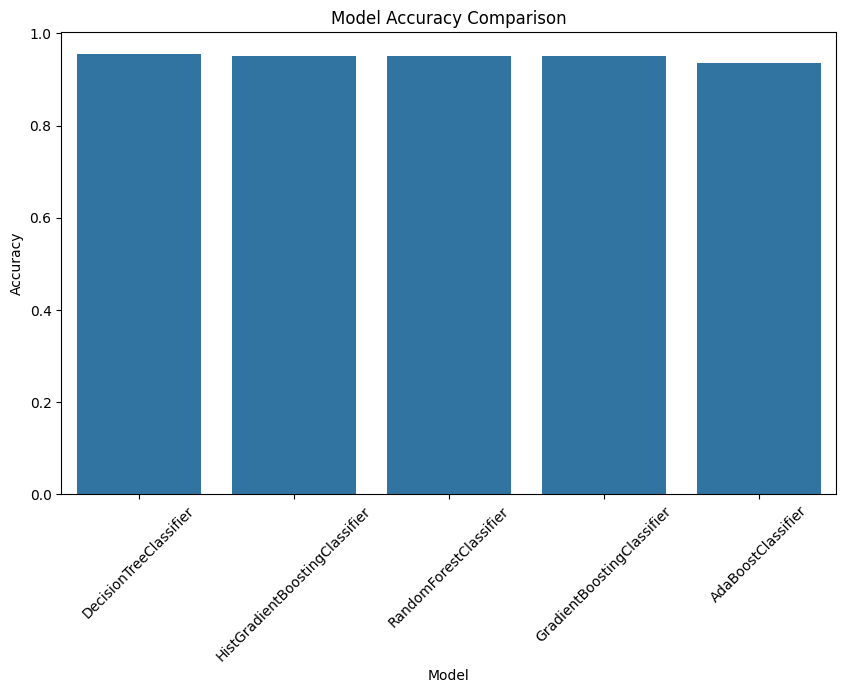

In [ ]:
data= {'Model': ['DecisionTreeClassifier', 'HistGradientBoostingClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier'],
        'Accuracy': [0.955, 0.95, 0.95, 0.95, 0.935]}
df = pd.DataFrame(data)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy',data=df)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# Cross Validation and Explaining

On the Above three models I will perform K-Fold cross validation along with ploting ROC and AUC curves. Later I will use Both Lime And Shap modules to generate the explanation.

ROC AUC for HistGradientBoostingClassifier: 0.991
ROC AUC for HistGradientBoostingClassifier: 0.997
ROC AUC for HistGradientBoostingClassifier: 0.995
ROC AUC for HistGradientBoostingClassifier: 0.992
ROC AUC for HistGradientBoostingClassifier: 0.996


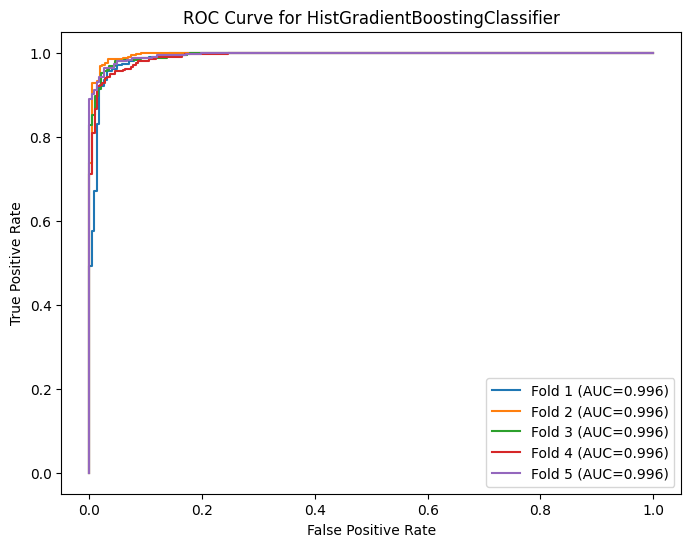

ROC AUC for RandomForestClassifier: 0.989
ROC AUC for RandomForestClassifier: 0.992
ROC AUC for RandomForestClassifier: 0.992
ROC AUC for RandomForestClassifier: 0.988
ROC AUC for RandomForestClassifier: 0.994


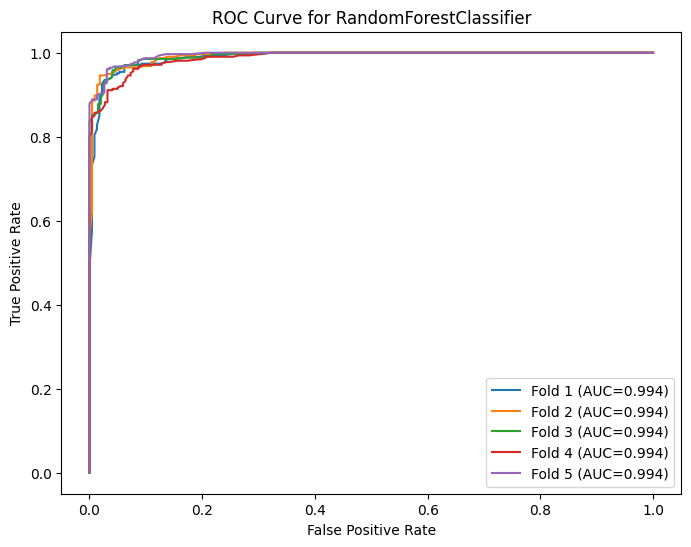

ROC AUC for GradientBoostingClassifier: 0.987
ROC AUC for GradientBoostingClassifier: 0.993
ROC AUC for GradientBoostingClassifier: 0.988
ROC AUC for GradientBoostingClassifier: 0.987
ROC AUC for GradientBoostingClassifier: 0.992


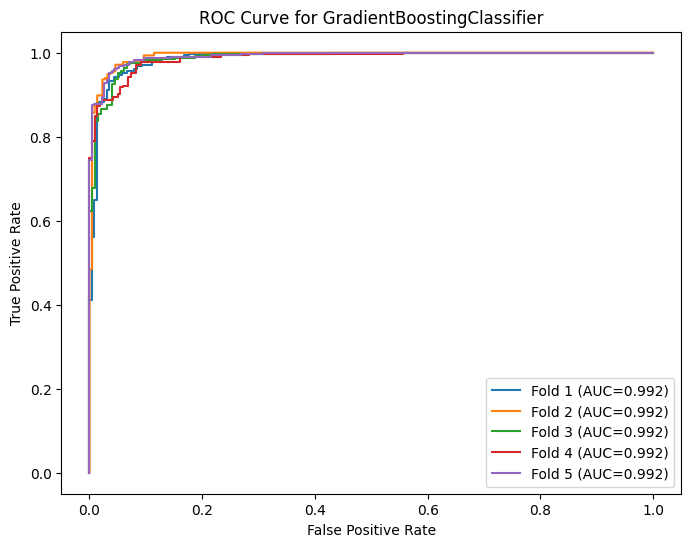

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_model_list =[HistGradientBoostingClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]

for model in best_model_list:
    all_fpr = []
    all_tpr = []
    for train_index, test_index in kf.split(features):
        x_train, x_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        model.fit(x_train, y_train)
        y_pred_proba = model.predict_proba(x_test)[:, 1]

        # Calculate ROC and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC for {model.__class__.__name__}: {roc_auc:.3f}")
        all_fpr.append(fpr)
        all_tpr.append(tpr)
    plt.figure(figsize=(8, 6))
    for i, (fpr, tpr) in enumerate(zip(all_fpr, all_tpr)):
        plt.plot(fpr, tpr, label=f"Fold {i+1} (AUC={roc_auc:.3f})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model.__class__.__name__}')
    plt.legend()
    plt.show()
    all_fpr.clear()
    all_tpr.clear()

### SHAP Explanation

Variable Importance Plot - UPI fraudDetection


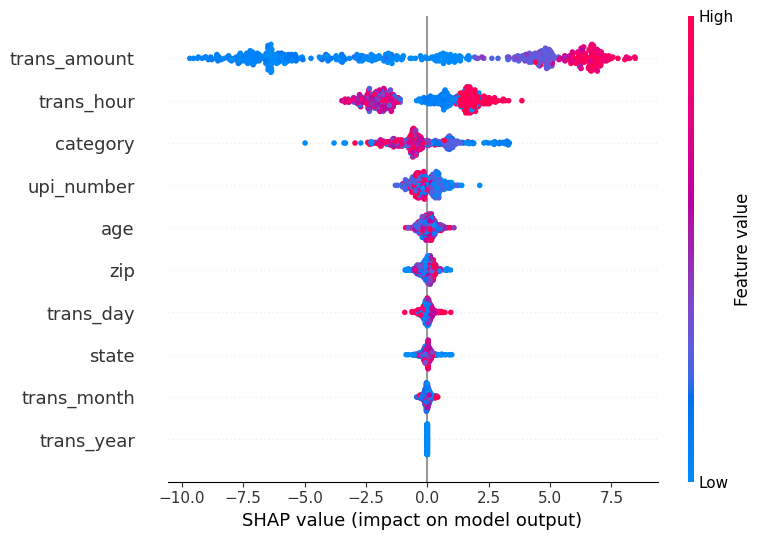

Variable Importance Plot - UPI fraudDetection


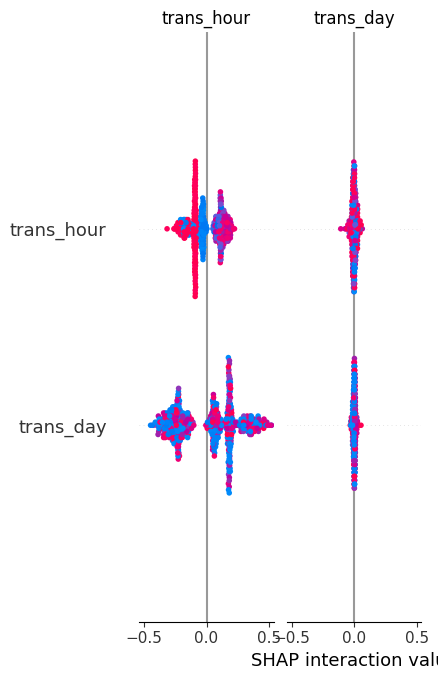

Variable Importance Plot - UPI fraudDetection


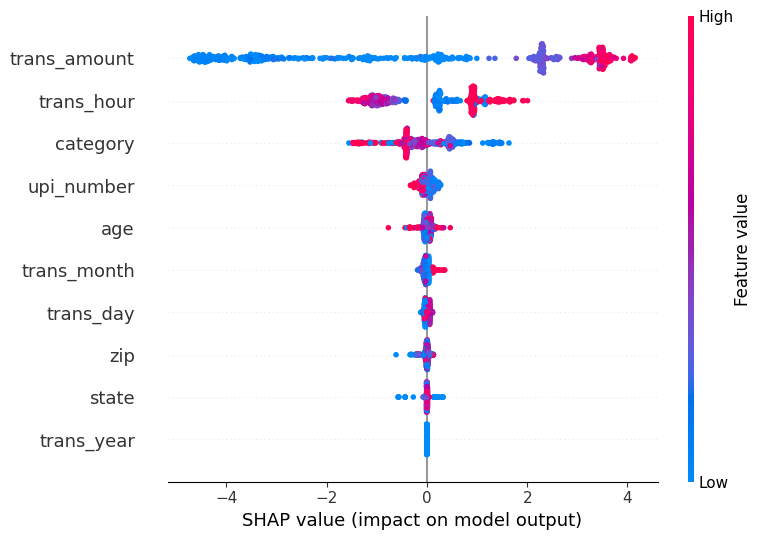

In [ ]:
for model in best_model_list:
    try:
        explainer = shap.TreeExplainer(model) if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier)) else shap.KernelExplainer(model.predict, x_train)
        shap_values = explainer.shap_values(x_test)
        print("Variable Importance Plot - UPI fraudDetection")
        shap.summary_plot(shap_values, x_test)
    except:
        pass  # Handle cases where SHAP explainer might not be applicable


#### LIME Explanation

In [ ]:
for model in best_model_list:
  if isinstance(model,  RandomForestClassifier):
          class_names = ['Fraudulent', 'Honest']
          feature_names = list(x_train.columns)
          explainer = lime_tabular.LimeTabularExplainer(x_train.values, feature_names=feature_names, class_names=class_names, mode='classification')
          instance = x_test.iloc[524]
          explanation = explainer.explain_instance(instance.values, best_model.predict_proba)
          explanation.show_in_notebook(show_table=True, show_all=False)
          plt.show()

  if isinstance(model, (HistGradientBoostingClassifier,GradientBoostingClassifier)):
          class_names = ['Fraudulent', 'Honest']
          feature_names = list(x_train.columns)
          explainer = lime_tabular.LimeTabularExplainer(x_train.values, feature_names=feature_names, class_names=class_names, mode='classification')
          instance = x_test.iloc[524]
          explanation = explainer.explain_instance(instance.values, best_model.predict_proba)
          explanation.show_in_notebook(show_table=True, show_all=False)
          plt.show()

# Summary <a id='8'></a>
[back to contents](#10)

## Conclusion <a id ="9"></a>
[back to contents](#10)